In [1]:
# Import modules used for the decision tree classifier & plot
from sklearn import preprocessing, neighbors, naive_bayes, neural_network, svm, tree
from sklearn.metrics import confusion_matrix,  roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.decomposition import PCA
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
from smote import smote_binary
from performance_report import performance_report

In [3]:
# Read the csv file, dropping the unnamed id column
# Show the first 5 rows after modification for review
dataset = pd.read_csv('all_disorders_remove_std.csv')
# Augment the data
# dataset = smote_multiclass(dataset, {0: 6000, 1: 6000, 2:6000, 3:6000}) #augmented dataframe
dataset.drop(['Gender'], 1, inplace=True)
dataset.head()

,Unnamed: 0,Status,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,0,1,0.014546,-0.000127,0.001828,0.063985,-0.181563,-0.409024,-0.076295,-0.151238,-0.220074,-1.024965
1,1,1,-0.046874,-0.000417,-0.026584,-0.072149,-0.263543,-0.594171,-0.149456,-0.189609,-0.215807,-0.867248
2,2,1,-0.016164,-0.000284,-0.016717,-0.034960,-0.316428,-0.586910,-0.192299,-0.226523,-0.252313,-1.067120
3,3,1,-0.008189,-0.000250,-0.007189,-0.042196,-0.220356,-0.056884,-0.131001,-0.158362,-0.172506,-0.740206
4,4,1,-0.040936,-0.000360,-0.029987,-0.091837,-0.312185,-0.605061,-0.201361,-0.212762,-0.195263,-0.901492


In [4]:
# Displaying the shape and datatype for each attribute
print(dataset.shape)
dataset.dtypes

(6684, 12)


Unnamed: 0            int64
Status                int64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
Jitter:PPQ5         float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
Shimmer:APQ11       float64
DFA                 float64
dtype: object

In [5]:
# Dispalying the descriptive statistics describe each attribute
dataset.describe()

,Unnamed: 0,Status,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
count,6684.000000,6684.000000,6.684000e+03,6.684000e+03,6.684000e+03,6.684000e+03,6.684000e+03,6.684000e+03,6684.000000,6.684000e+03,6.684000e+03,6.684000e+03
mean,3341.500000,0.973668,-1.594575e-18,1.575889e-17,1.355389e-17,2.365287e-17,-8.504401e-17,-6.803521e-17,0.000000,4.677421e-17,-8.504401e-17,-7.101175e-16
std,1929.648932,0.204456,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075,1.000075e+00,1.000075e+00,1.000075e+00
min,0.000000,0.000000,-3.221790e+01,-2.133261e+01,-2.485212e+01,-3.169470e+01,-2.268886e+01,-7.370397e+00,-19.637068,-2.592986e+01,-2.806578e+01,-2.319419e+01
25%,1670.750000,1.000000,-4.365040e-02,-3.739481e-04,-2.454283e-02,-6.996109e-02,-2.696799e-01,-5.869099e-01,-0.153782,-1.799356e-01,-2.248151e-01,-5.369574e-01
50%,3341.500000,1.000000,-1.972693e-02,-1.591528e-04,-1.246347e-02,-3.344573e-02,-1.292087e-01,-2.747028e-01,-0.074482,-8.663868e-02,-1.000474e-01,-4.923873e-02
75%,5012.250000,1.000000,1.318906e-02,1.732685e-04,5.102652e-03,1.989699e-02,9.642399e-02,2.081291e-01,0.063602,6.227207e-02,8.414094e-02,5.969933e-01
max,6683.000000,3.000000,3.521828e+01,6.154689e+01,4.249125e+01,3.045492e+01,4.170042e+01,6.430489e+00,40.354223,3.804147e+01,3.171104e+01,1.973819e+01


<AxesSubplot:>

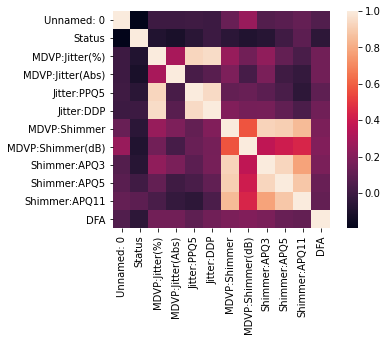

In [6]:
# Heatmap visulisation for each attribute coefficient correlation.
import seaborn as sb
corr_map=dataset.corr()
sb.heatmap(corr_map,square=True)

<AxesSubplot:>

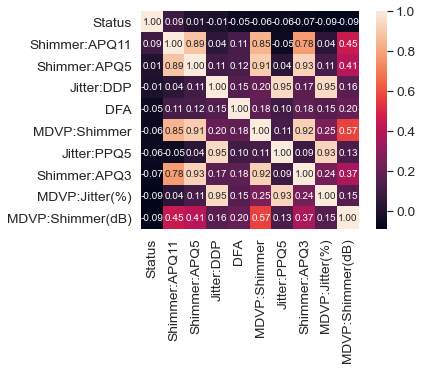

In [7]:
# Now visualise the heat map with correlation coefficient values for pair of attributes.
import matplotlib.pyplot as plt
import numpy as np

# K value means how many features required to see in heat map
k=10

# finding the columns which related to output attribute and we are arranging from top coefficient correlation value to downwards.
cols=corr_map.nlargest(k,'Status')['Status'].index

# correlation coefficient values
coff_values=np.corrcoef(dataset[cols].values.T)
sb.set(font_scale=1.25)
sb.heatmap(coff_values,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 10},yticklabels=cols.values,xticklabels=cols.values)

In [8]:
# correlation coefficient values in each attributes.
correlation_values=dataset.corr()['Status']
correlation_values.abs().sort_values(ascending=False)

Status              1.000000
Unnamed: 0          0.194969
MDVP:Jitter(Abs)    0.112093
Shimmer:APQ11       0.092427
MDVP:Shimmer(dB)    0.089476
MDVP:Jitter(%)      0.088089
Shimmer:APQ3        0.069038
Jitter:PPQ5         0.062585
MDVP:Shimmer        0.059317
DFA                 0.054606
Shimmer:APQ5        0.007817
Jitter:DDP          0.005724
Name: Status, dtype: float64

In [9]:
# split the dataset into input and output attribute.
X = dataset.iloc[:,[2,3,4,5,6,7,8,9,10,11]].values
y = dataset.iloc[:,1].values

In [10]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [11]:
# Fitting Classifier to the Training Set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [12]:
# Model performance on training set
y_pred_train =classifier.predict(X_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.3f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train))

Accuracy: 0.974
Confusion Matrix: 
 [[  74   98    0    2]
 [  35 5116    0    0]
 [   4    0    8    0]
 [   0    0    1    9]]
              precision    recall  f1-score   support

           0       0.65      0.43      0.52       174
           1       0.98      0.99      0.99      5151
           2       0.89      0.67      0.76        12
           3       0.82      0.90      0.86        10

    accuracy                           0.97      5347
   macro avg       0.84      0.75      0.78      5347
weighted avg       0.97      0.97      0.97      5347



In [13]:
# Predicting the test results
y_pred=classifier.predict(X_test)

# Classification results on test set
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(accuracy))

from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred))

Accuracy: 0.971
Confusion Matrix: 
 [[  19   23    0    1]
 [  13 1275    0    0]
 [   1    0    2    0]
 [   1    0    0    2]]
              precision    recall  f1-score   support

           0       0.56      0.44      0.49        43
           1       0.98      0.99      0.99      1288
           2       1.00      0.67      0.80         3
           3       0.67      0.67      0.67         3

    accuracy                           0.97      1337
   macro avg       0.80      0.69      0.74      1337
weighted avg       0.97      0.97      0.97      1337



/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 288, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 226

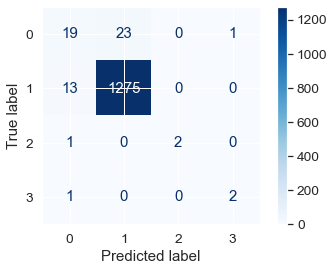

In [14]:
performance_report(classifier, X, y, X_test, y_test, y_pred, 'multi1_all_remove_no_smote')
